## Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Population Initialization

In [2]:
def initialize_population(num_individuals, num_variables):
    return np.random.randint(2, size=(num_individuals, num_variables))

## Evaluation Functions

In [3]:
def onemax(ind):
    return np.sum(ind)

In [4]:
def leadingone(ind):
    for i in range(len(ind)):
        if ind[i] == 0:
            return i
    return len(ind)

In [5]:
def trap5(ind):
    sum_k = np.sum(ind)
    if sum_k == 5:
        return 5
    return 4 - sum_k

def concatenated_trap5(ind):
    sum = 0
    for idx in range(0, len(ind), 5):
        sum += trap5(ind[idx:idx+5])
    return sum

## Crossover (Recombination)

In [ ]:
def crossover( pop ):
    """
    Hàm biến đổi tạo ra các cá thể con.

    Arguments:
    pop -- Quàn thể hiện tại.

    Returns:
    offspring -- Quần thể chứa các cá thể con được sinh ra.
    """

    num_individuals = len(pop)
    num_parameters = len(pop[0])
    indices = np.arange(num_individuals)
    np.random.shuffle(indices)
    offspring = []

    for i in range(0, num_individuals, 2):
        idx1 = indices[i]
        idx2 = indices[i+1]
        offspring1 = list(pop[idx1])
        offspring2 = list(pop[idx2])

        for idx in range(0, num_parameters):
            r = np.random.rand()
            if r < 0.5:
                temp = offspring2[idx]
                offspring2[idx] = offspring1[idx]
                offspring1[idx] = temp

        offspring.append(offspring1)
        offspring.append(offspring2)

    offspring = np.array(offspring)
    return offspring

## Selection Methods

In [7]:
def truncation_selection(pop, pop_fitness, selection_size):
    selected_indices = np.argsort(pop_fitness)[-selection_size:]
    
    return pop[selected_indices], pop_fitness[selected_indices]

def tournament_selection(pop, pop_fitness, selection_size, tournament_size=4):
    num_individuals = len(pop)
    selected = []

    while len(selected) < selection_size:
            indices = np.arange(num_individuals)
            np.random.shuffle(indices)

            for i in range(0, num_individuals, tournament_size):
                tournament_indices = indices[i:i + tournament_size]
                winner_idx = tournament_indices[np.argmax(pop_fitness[tournament_indices])]
                selected.append(winner_idx)

    return pop[selected[:selection_size]], pop_fitness[selected[:selection_size]]

def proportional_selection(pop, pop_fitness, selection_size):
    total_fitness = np.sum(pop_fitness)
    if total_fitness == 0:
        return pop[np.random.choice(len(pop), selection_size, replace=True)]
    
    selection_prob = pop_fitness / total_fitness
    cumulative_prob = np.cumsum(selection_prob)
    
    selected_indices = np.searchsorted(cumulative_prob, np.random.rand(selection_size), side='right')
    return pop[selected_indices], pop_fitness[selected_indices]


## Genetic Algorithm with POPOP implementation

In [ ]:
def genetic_algorithm(objective, num_individuals, num_parameters, max_evaluations, selection_method):
    pop = initialize_population(num_individuals, num_parameters)
    pop_fitness = np.array([objective(ind) for ind in pop])
    num_evaluations = num_individuals
    best_fitness = []

    selection_size = num_individuals
    while num_evaluations < max_evaluations:
        best_fitness.append([num_evaluations, np.max(pop_fitness)])
        offspring = crossover(pop)
        offspring_fitness = np.array([objective(ind) for ind in offspring])
        num_evaluations += len(offspring)
        pop = np.vstack([pop, offspring])
        pop_fitness = np.hstack([pop_fitness, offspring_fitness])

        if selection_method == "tournament":
            pop, pop_fitness = tournament_selection(pop, pop_fitness, selection_size)
        elif selection_method == "truncation":
            pop, pop_fitness = truncation_selection(pop, pop_fitness, selection_size)
        elif selection_method == "proportional":
            pop, pop_fitness = proportional_selection(pop, pop_fitness, selection_size)
        else:
            raise ValueError("Please select a valid selection method: tournament, truncation, or proportional")

    best_fitness.append([num_evaluations, np.max(pop_fitness)])

    return (pop, pop_fitness, best_fitness)


In [52]:
def run_benchmark(objective, num_trials, num_parameters, max_evaluations, population_sizes, selection_methods, base_seed, benchmark_name):
    seeds = np.array([base_seed + i for i in range(num_trials)])
    colors = {"tournament": "r", "truncation": "b", "proportional": "g"}
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, num_individuals in enumerate(population_sizes):
        results = {method: [] for method in selection_methods}
        evals = None

        for method in selection_methods:
            fitness_trials = []
            for seed in seeds:
                np.random.seed(seed)
                pop, pop_fitness, best_fitness = genetic_algorithm(
                    objective, num_individuals, num_parameters, max_evaluations, method
                )
                best_fitness = np.array(best_fitness)

                if evals is None:
                    evals = best_fitness[:, 0]

                fitness_trials.append(best_fitness[:, 1])

            results[method] = np.array(fitness_trials)

        avg_fitness = {key: np.mean(val, axis=0) for key, val in results.items()}
        std_fitness = {key: np.std(val, axis=0) for key, val in results.items()}
        
        ax = axes[idx]
        for selection_method in results:
            avg = avg_fitness[selection_method]
            err = std_fitness[selection_method]
            ax.plot(evals, avg, label=selection_method.capitalize(), color=colors[selection_method])
            ax.fill_between(evals, avg + err, avg - err, facecolor=colors[selection_method], alpha=0.1)
        
        ax.set_xlabel("Evaluations")
        ax.set_ylabel("Fitness")
        ax.set_xlim(0, max_evaluations + num_individuals)
        ax.set_title(f"Pop Size: {num_individuals}")
        ax.legend()
        ax.grid()
    
    plt.suptitle(f"{benchmark_name} with {num_parameters} bit")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


## Experiments

### Observation

#### OneMax with 100 bit

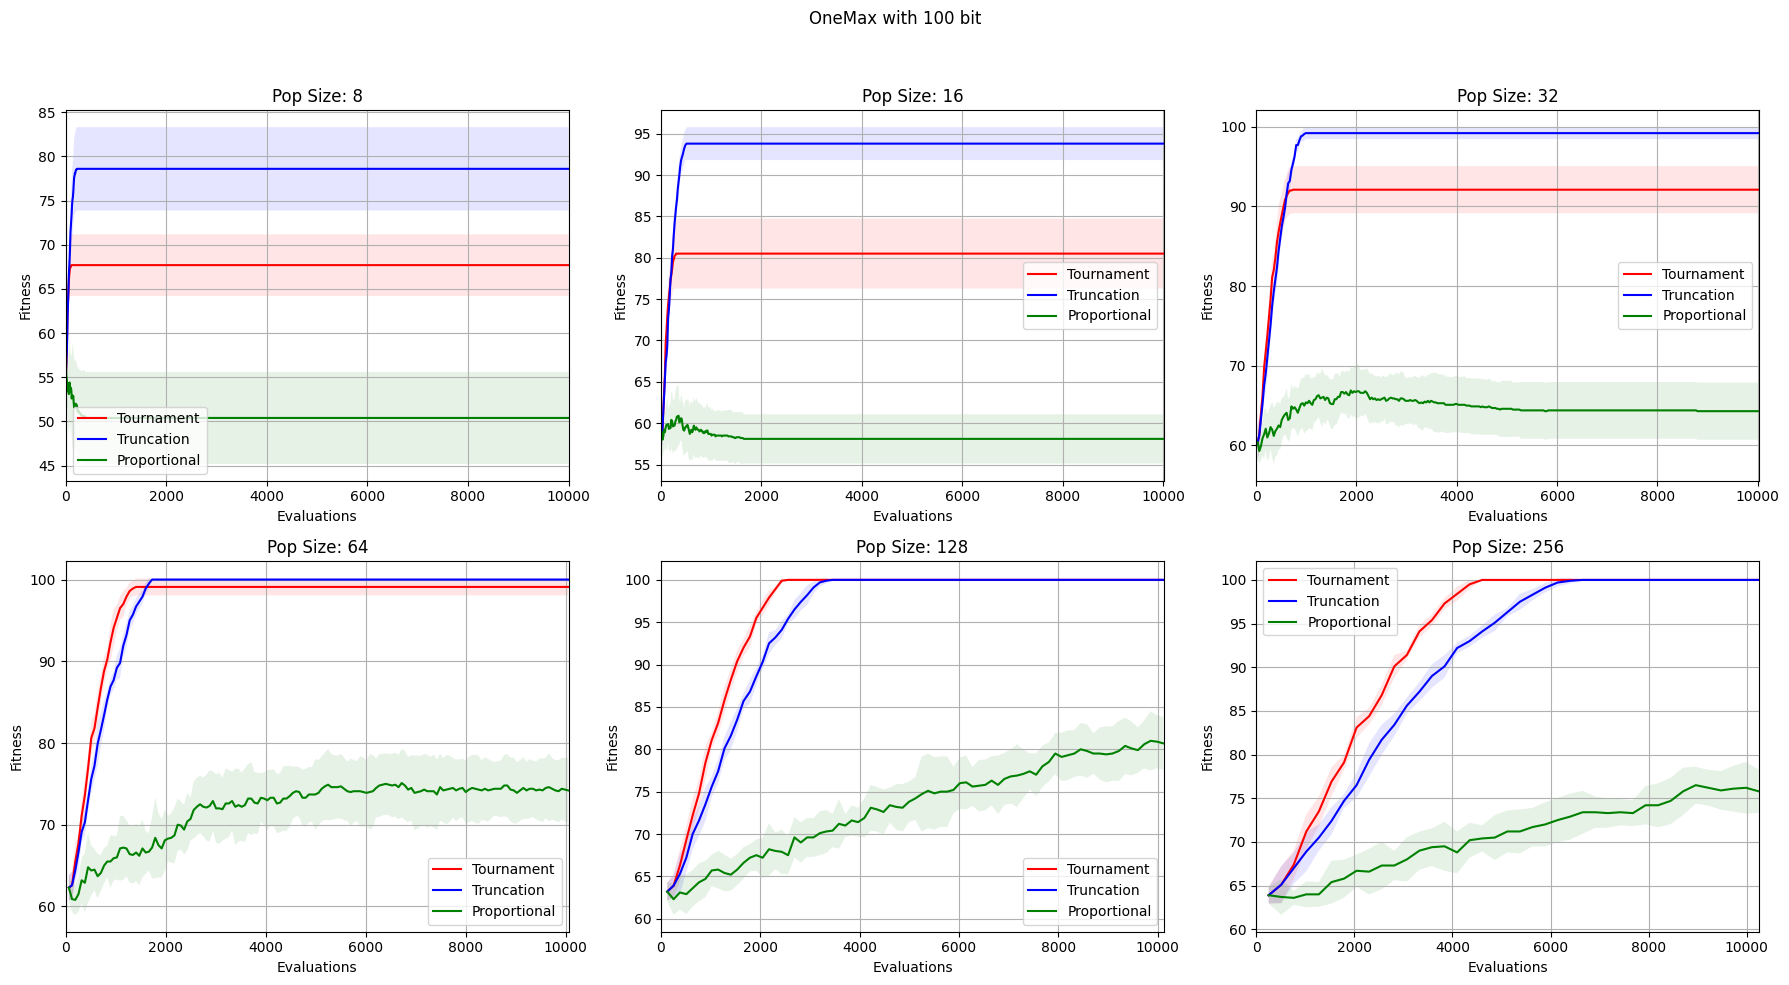

In [53]:
run_benchmark(onemax, 10, 100, 10000, [8, 16, 32, 64, 128, 256], ["tournament", "truncation", "proportional"], 22520467, "OneMax")

#### LeadingOne with 20 bit

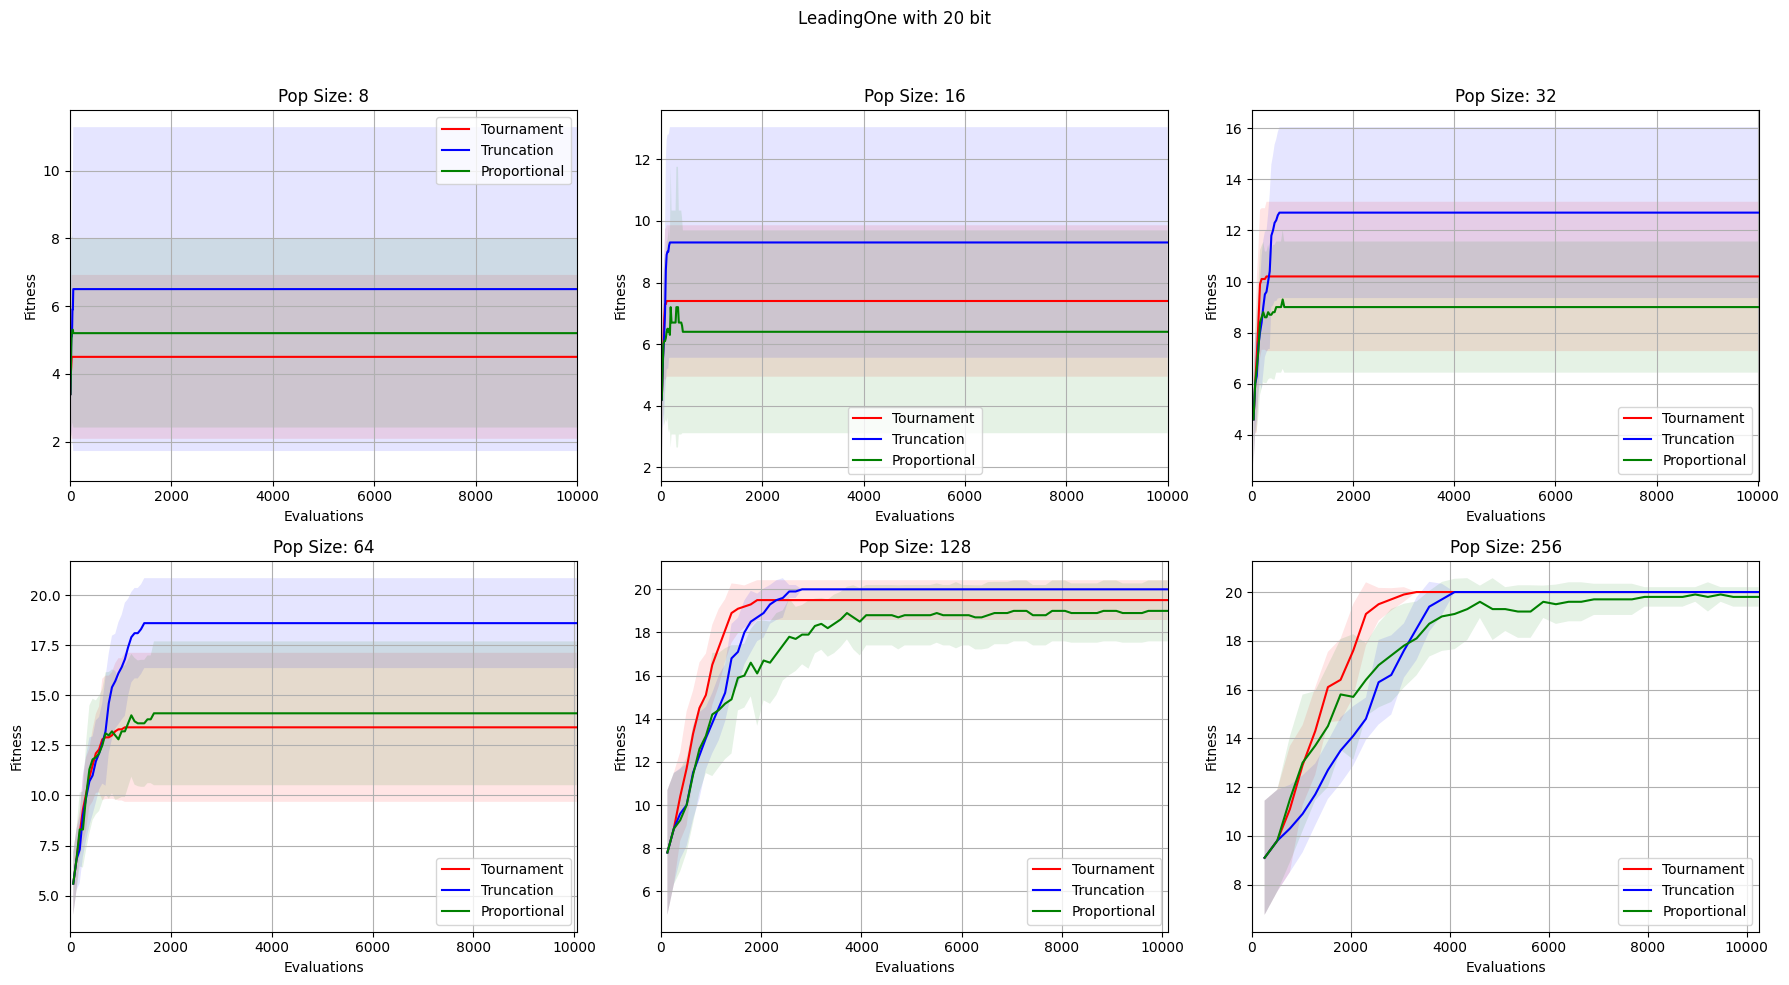

In [59]:
run_benchmark(leadingone, 10, 20, 10000, [8, 16, 32, 64, 128, 256], ["tournament", "truncation", "proportional"], 22520467, "LeadingOne")

#### ConcatenatedTrap5 with 25 bit

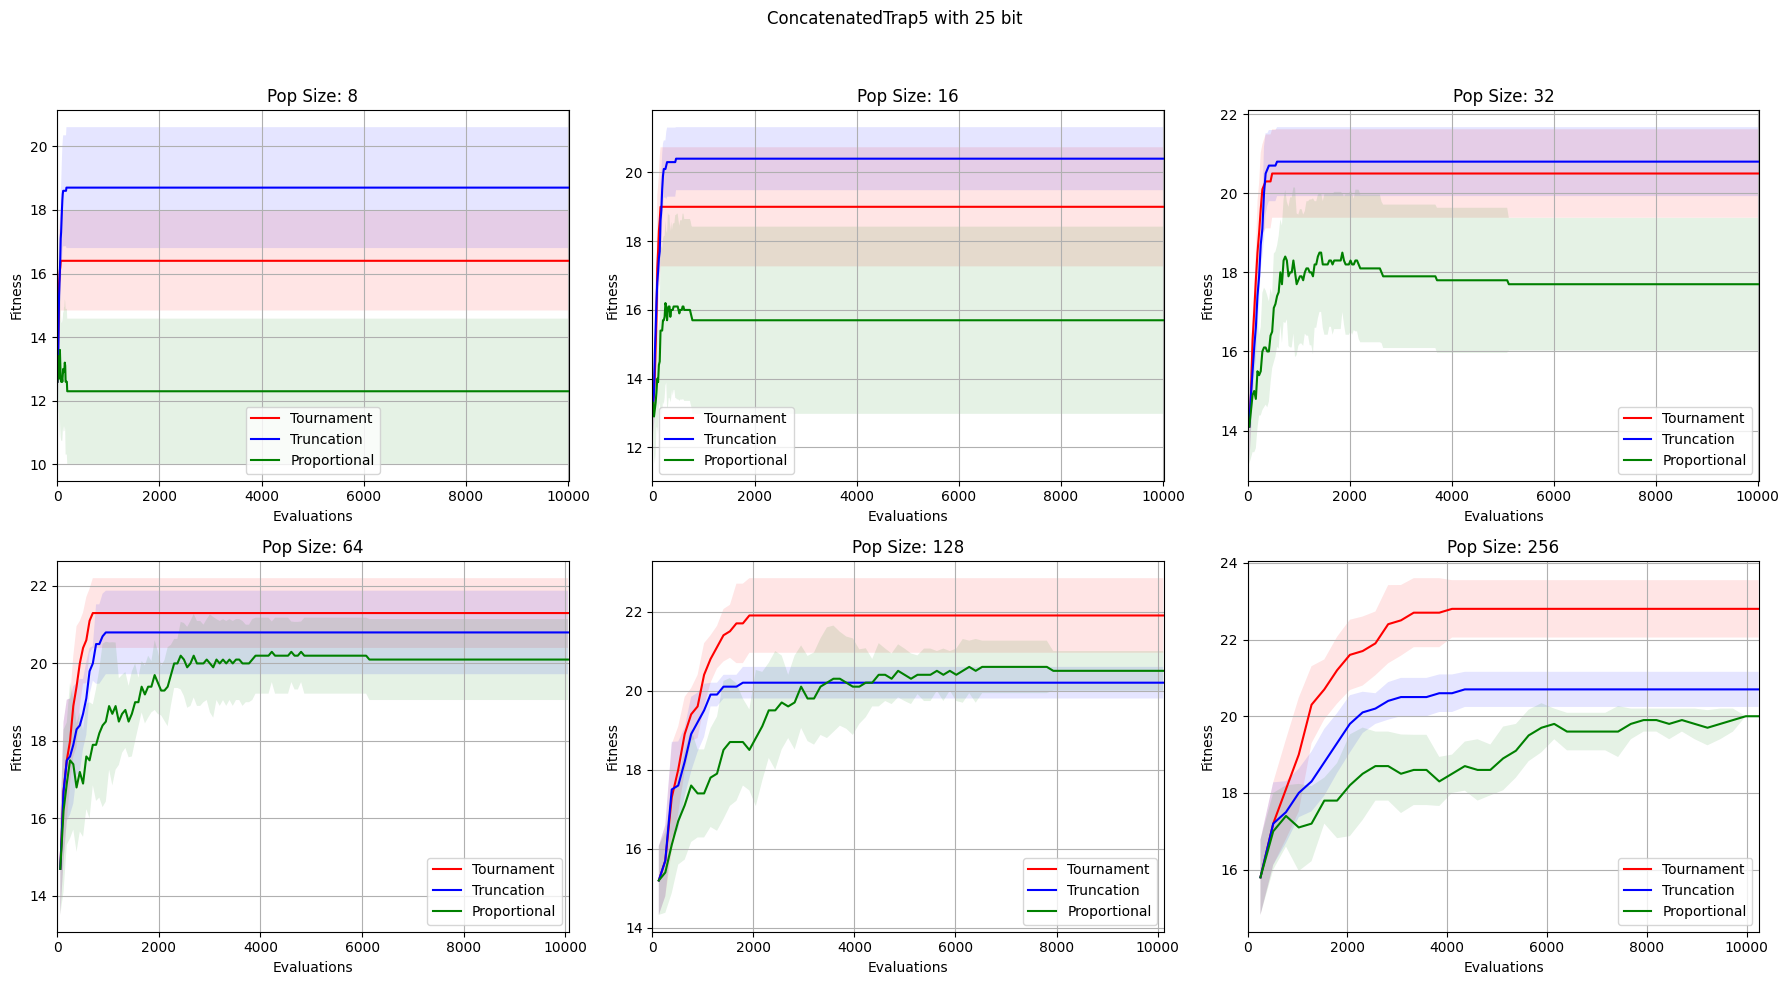

In [63]:
run_benchmark(concatenated_trap5, 10, 25, 10000, [8, 16, 32, 64, 128, 256], ["tournament", "truncation", "proportional"], 22520467, "ConcatenatedTrap5")

### Analysis

#### OneMax

- Khi kích thước quần thể nhỏ hơn 128, truncation selection đạt hiệu năng tốt nhất. Cụ thể, với pop size = 64, truncation selection đã đạt fitness 100, trong khi tournament selection cần đến pop size = 128 mới đạt được kết quả tương tự. Điều này cho thấy truncation selection đạt hiệu năng tốt hơn khi làm việc với quần thể nhỏ.

- Khi kích thước quần thể từ 128 trở lên, tournament selection đạt hiệu năng tốt hơn. Mặc dù cả hai phương pháp tournament và truncation đều đạt fitness 100, nhưng tournament selection hội tụ nhanh hơn (tính theo số lần evaluation).

- Proportional selection có hiệu suất kém nhất trong tất cả các kích thước quần thể thử nghiệm (8, 16, ..., 256). Khi thực hiện 10,000 evaluations thuật toán vẫn chưa hội tụ. Với quần thể nhỏ, thuật toán có hội tụ nhưng độ thích nghi khá thấp (fitness ≈ 50 với pop size 8, < 60 với pop size 16,..., khoảng 80 với pop size 128).

#### LeadingOne

- Khi kích thước quần thể nhỏ hơn 128, truncation selection đạt hiệu năng tốt nhất. Cụ thể, khi dùng truncation selection với pop size = 64, giá trị fitness đạt được cao hơn so với khi dùng tournament selection và proportional selection. Khi dùng tournament selection, thuật toán hội tụ sớm nhưng không đạt được fitness tối đa. Khi dùng proportional selection, hiệu năng gần tương đồng với tournament selection.

- Khi kích thước quần thể bằng 128, khi dùng truncation selection, quần thể sau hội tụ đạt độ thích nghi tối đa. Khi dùng tournament selection và proportional selection, quần thể đạt giá trị fitness gần mức tối đa (≈ 19), nhưng khi dùng proportional selection, thuật toán chưa có xu hướng hội tụ rõ ràng.

- Khi kích thước quần thể là 256, khi dùng proportional selection, thuật toán có xu hướng hội tụ sau 10,000 evaluations và đạt fitness ≈ 20. Khi dùng tournament selection và truncation selection, cả hai phương pháp đều giúp quần thể đạt độ thích nghi tối đa, nhưng khi dùng tournament selection, thuật toán hội tụ nhanh hơn (tính theo số lần evaluations).

#### ConcatenatedTrap5

- Khi kích thước quần thể từ 8 cho tới 32, truncation selection đạt hiệu năng tốt nhất. Cụ thể, khi dùng truncation selection với pop size = 32, giá trị fitness đạt được cao hơn so với khi dùng tournament selection và proportional selection. Với kích thước quần thể như vậy thì tuy thuật toán đã hội tụ nhưng fitness đều đạt không cao so với độ thích nghi tối đa có thể đạt được khi thử nghiệm với benchmark này.
  
- Khi kích thước quần thể từ 64 tới 256, tournament selection hoạt động tốt hơn so với hai phương pháp chọn lọc còn lại. Tuy vậy với số population size hiện tại và số evaluation hiện tại thì tuy thuật toán có hội tụ nhưng fitness vẫn chưa đạt được tối đa, điều này có thể do số lượng quần thể chưa đủ đa dạng để thoát khỏi "bẫy" của benchmark. 
  
- Dựa trên kết quả thực nghiệm với num_evaluations = 100,000 và kích thước quần thể = 4096, phương pháp tournament selection cho thấy hiệu quả vượt trội khi giúp thuật toán đạt fitness > 24. Trong khi đó, cả hai phương pháp truncation selection và proportional selection đều không thể vượt qua ngưỡng fitness = 22.

#### Conclusion

- Tournament selection hoạt động ổn định và hiệu quả khi kích thước quần thể đủ lớn. Phương pháp này giúp thuật toán hội tụ nhanh hơn so với các phương pháp khác, nhưng khi quần thể nhỏ, nó có nguy cơ hội tụ sớm mà không đạt được fitness tối đa.

- Truncation selection hoạt động tốt khi kích thước quần thể nhỏ hoặc trung bình. Nó có hiệu năng cao hơn tournament selection khi quần thể nhỏ, nhưng khi quần thể lớn, nó hội tụ chậm hơn so với phương pháp tournament selection.

- Proportional selection có hiệu năng kém nhất trong cả ba phương pháp. Phương pháp này tồn tại nhược điểm rằng không đảm bảo những cá thể tốt nhất được lựa chọn nên kể cả khi nó hội tụ thì vẫn có khả năng fitness đạt được không cao.

Nhìn chung, tournament selection phù hợp khi quần thể lớn, truncation selection hiệu quả hơn khi quần thể nhỏ, còn proportional selection thường không đạt hiệu suất cao. Qua thử nghiệm với các kích thước quần thể 8, 16, 32, 64, và 128, quần thể có kích thước 128 cho hiệu suất tốt nhất